In [ ]:
from google.colab import drive
drive.mount('MyDrive')

Mounted at MyDrive


In [ ]:
import librosa
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the path to your audio data folder on Google Drive (replace with your path)
data_path = '/content/drive/MyDrive/KTH/aMASTER THESIS/Data/dataset'

# Function to extract features from an audio file
def compute_spectral_features(y, sr, n_fft=2048, hop_length=512):
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=25)[1:, :]
  centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
  flatness = librosa.feature.spectral_flatness(y=y, n_fft=n_fft, hop_length=hop_length)
  contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
  zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=n_fft, hop_length=hop_length)
  rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)

  return mfccs, centroid, flatness, contrast, rolloff, zcr, rms


def summarize_spectral_features(matrix):
  summary_matrix = np.zeros((matrix.shape[0], 4))
  for i in range(matrix.shape[0]):
    this_row = matrix[i, :]
    mean = np.mean(this_row)
    std = np.std(this_row)
    skewness = stats.skew(this_row)
    kurtosis = stats.kurtosis(this_row)
    summary_matrix[i, :] = np.array([mean, std, skewness, kurtosis])

  return summary_matrix


waveform, sample_rate = librosa.load("/content/MyDrive/MyDrive/KTH/aMASTER THESIS/Data/dataset/025_025_025_025_025_025_025_025.wav")
mfccs, centroid, flatness, contrast, rolloff, zcr, rms = compute_spectral_features(waveform, sample_rate)
print(mfccs.shape, centroid.shape, flatness.shape, contrast.shape, rolloff.shape, zcr.shape, rms.shape)
matrix = np.vstack((mfccs, centroid, flatness, contrast, rolloff, zcr, rms))
print(matrix.shape)
summary_matrix = summarize_spectral_features(matrix)
print(summary_matrix.shape)



(24, 87) (1, 87) (1, 87) (7, 87) (1, 87) (1, 87) (1, 87)
(36, 87)
(36, 4)


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchaudio
from torchaudio import transforms
import matplotlib.pyplot as plt



class BenjoDataset(Dataset):
    def __init__(self, data_dir, num_mfccs=90, features='mfcc-2d', device='cuda'):
        self.data_dir = data_dir
        self.features = features
        self.device = device
        self.num_mfccs = num_mfccs
        self.files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".wav")]
        self.means = np.array([9.03751466e+01, -4.87711382e+01,  1.00106690e+01, -3.67655399e+01,
                  1.32894495e+01, -2.29232664e+01,  2.10991129e+01, -1.42567998e+01,
                  1.41439440e+01, -1.19595448e+01,  4.25738868e+00, -1.03713474e+01,
                  4.29204911e+00, -4.74454036e+00, -3.32680304e+00,  3.47158477e-01,
                  -9.87375813e+00, -1.63118550e+00, -1.00760688e+01, -2.16688586e+00,
                  -2.85188729e+00, -1.25815090e+00, -7.54625020e-01, -2.02014818e-02,
                  2.66066705e+03,  3.15197961e-02,  1.70497149e+01,  1.13744539e+01,
                  1.42730806e+01,  1.52678552e+01,  1.50953842e+01,  1.60024830e+01,
                  5.54366389e+01,  5.38840624e+03,  1.68883268e-01,  7.84309217e-04])
        self.stds = np.array([2.73570436e+01, 2.27701783e+01, 1.43011673e+01, 1.69188193e+01,
                  1.07046671e+01, 1.13737165e+01, 9.67528858e+00, 9.65926391e+00,
                  1.00187896e+01, 9.16620476e+00, 9.03847915e+00, 7.92779680e+00,
                  8.35381927e+00, 6.54498904e+00, 5.59145123e+00, 5.47152959e+00,
                  6.05296162e+00, 5.72936458e+00, 5.99672456e+00, 5.62927500e+00,
                  5.41780984e+00, 6.04045119e+00, 5.22260702e+00, 5.19501183e+00,
                  6.87218532e+02, 2.12050108e-02, 5.82636046e+00, 3.51899648e+00,
                  3.66860123e+00, 3.22526246e+00, 2.46679054e+00, 2.21150898e+00,
                  8.52658216e+00, 1.39463372e+03, 6.92357879e-02, 1.27763815e-03])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
      path = self.files[index]

      waveform, sr = librosa.load(path)
      mfccs, centroid, flatness, contrast, rolloff, zcr, rms = compute_spectral_features(waveform, sample_rate)
      matrix = np.vstack((mfccs, centroid, flatness, contrast, rolloff, zcr, rms))
      matrix -= self.means[:, np.newaxis]
      matrix /= self.stds[:, np.newaxis]
      summary_matrix = summarize_spectral_features(matrix)
      tensor = torch.tensor(summary_matrix, dtype=torch.float32).to(self.device)
      tensor = torch.clamp(tensor, min=-5, max=5)
      return tensor.reshape(12, 12)


    def __getitem__1(self, index):
        path = self.files[index]

        if self.features == 'params':
            params_array, _ = self.get_benjo_params(index)
            return torch.tensor(params_array, dtype=torch.float32).to(self.device) / 126

        waveform, sample_rate = torchaudio.load(path, normalize=True, format='wav')
        waveform = waveform[0, :].to(self.device)

        transform = transforms.MelSpectrogram(sample_rate, power=1, n_mels=40, n_fft=400).to(self.device)
        mel_specgram = torch.log(transform(waveform) + 0.001) + 7
        mel_specgram = torch.clamp(mel_specgram / 6, min=0, max=1)
        # mel_specgram = torch.clip((torch.log(transform(waveform)) + 5) / 1.24, min=-2.5, max=2.5)
        rand = np.random.randint(0, 442)
        mel_specgram = torch.cat((mel_specgram[:, rand:], mel_specgram[:, :rand]), dim=1)[:, :440]
        return mel_specgram[:, :440].view(1, 40, 440)

    def get_benjo_params(self, index):
        path = self.files[index]
        params_string = path.removeprefix(self.data_dir + '/').removesuffix('.wav')
        params_list = params_string.split('-')
        params_array = np.array(list(map(int, params_list)))
        return params_array, params_string



data_dir = "/content/MyDrive/MyDrive/KTH/aMASTER THESIS/Data/dataset"
dataset = BenjoDataset(data_dir)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
device = "cuda"
print(dataset[0].shape)



torch.Size([12, 12])


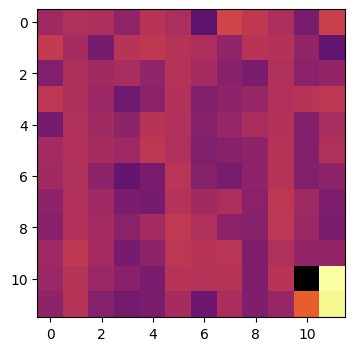

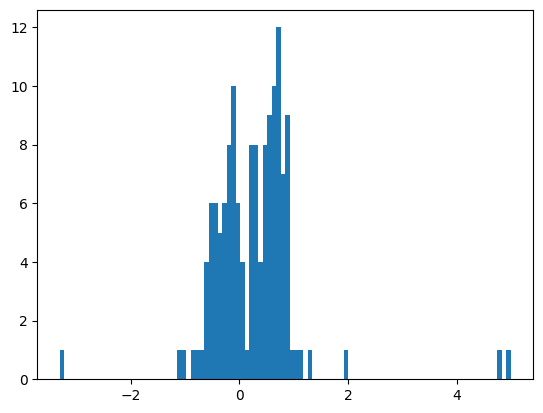

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(4, 4), dpi=100)
index = 8
plt.imshow(dataset[index].cpu().detach().numpy(), cmap='inferno', interpolation='nearest')
plt.show()
plt.hist(dataset[index].cpu().detach().numpy().flatten(), bins=100)
plt.show()


In [ ]:
arr = np.zeros(shape=(36, 87*255))
for i in range(255):
  arr[:, i*87:(i+1)*87] = dataset[i]
  if i % 10 == 0:
    print(i)

print(arr.shape)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
(36, 22185)


In [ ]:
mean = np.mean(arr, axis=1)
std = np.std(arr, axis=1)
print(arr.min(axis=1))
print(arr.max(axis=1))
print(mean)
print(std)
"""plt.hist(arr.flatten(), bins=100, range=(0, 1))
plt.show()"""

[-1.58639681e+00 -1.45664917e+02 -6.01600800e+01 -8.76707611e+01
 -4.28168106e+01 -6.72013550e+01 -4.03131866e+01 -5.99777832e+01
 -2.49287109e+01 -6.08097229e+01 -4.53838882e+01 -4.44625397e+01
 -4.86345978e+01 -3.30573273e+01 -2.85673027e+01 -2.55572929e+01
 -4.06671715e+01 -2.59480209e+01 -4.66442451e+01 -3.15153885e+01
 -2.67087746e+01 -2.49519157e+01 -2.78929291e+01 -2.21039314e+01
  5.06872683e+02  3.48509093e-05  2.30166832e+00  2.04299832e+00
  2.45768804e+00  3.31891855e+00  5.39164019e+00  9.52796527e+00
  3.40167656e+00  4.52197266e+02  1.17187500e-02  4.70555024e-05]
[2.31564621e+02 4.18893738e+01 8.43332977e+01 3.19151421e+01
 7.40970459e+01 2.02354527e+01 6.03999901e+01 2.38700180e+01
 5.26968460e+01 2.91221275e+01 6.18898697e+01 2.85165195e+01
 3.58829269e+01 2.78867779e+01 2.67264538e+01 3.47028046e+01
 2.28218651e+01 3.99650497e+01 1.17806816e+01 2.21908646e+01
 2.53204346e+01 3.73591003e+01 3.67411423e+01 2.48075294e+01
 6.22339038e+03 2.14422554e-01 5.19529296e+01 3.

'plt.hist(arr.flatten(), bins=100, range=(0, 1))\nplt.show()'

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class ConvVAE(nn.Module):
  def __init__(self, in_channels=1, latent_dim=2, input_dims=[40, 440], n_layers=2):
    super(ConvVAE, self).__init__()
    self.in_channels = in_channels
    self.latent_dim = latent_dim
    self.input_dims = input_dims
    self.hidden_dim = (self.input_dims[0] // (n_layers * 2)) * (self.input_dims[1] // (n_layers * 2))

    ## Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels, 2, kernel_size=3, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(2, 4, kernel_size=3, stride=2, padding=1),
        nn.ReLU(inplace=True)
    )

    ## Latent space
    self.fc1 = nn.Linear(self.hidden_dim*4, latent_dim)
    self.fc2 = nn.Linear(self.hidden_dim*4, latent_dim)

    ## Decoder
    self.fcDec = nn.Linear(self.latent_dim, self.hidden_dim)
    self.relu = nn.ReLU(inplace=True)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(1, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    x = self.encoder(x)

    x = x.view(x.size(0), -1)

    mu = self.fc1(x)
    logvar = self.fc2(x)
    z = self.reparameterize(mu, logvar)
    x = self.fcDec(z)
    x = self.relu(x)
    x = x.view(x.size(0), -1, 10, 110)
    x = self.decoder(x)
    return x, mu, logvar


In [ ]:
model = ConvVAE(1, 2, [40, 440]).to(device)
x, mu, logvar = model(dataset[0].view(1, 1, 40, 440))
print(x.shape)

torch.Size([1, 1, 40, 440])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
import torch
import numpy as np
from torch.cuda.amp import GradScaler


def kl_divergence(mu, log_var, beta):
    # mu.shape = (batch_size, latent)
    kl = torch.sum(-0.5 * (1 + log_var - mu ** 2 - torch.exp(log_var)), dim=1)  # (batch_size, 1)
    kl = torch.mean(kl)  # (1)
    return kl * beta


def train(vae, training_data, epochs, opt='SGD', beta=1e-5, lr=1e-4, gamma=0.95, device='cuda'):
    training_losses = np.array([])
    opt = torch.optim.SGD(vae.parameters(), lr=lr) if opt == 'SGD' else torch.optim.Adam(vae.parameters(), lr=lr)
    scaler = GradScaler()
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=gamma)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=3)
    MSELoss = torch.nn.MSELoss(reduction='mean')
    for epoch in range(epochs):
        loss_this_epoch = 0
        for i, x in enumerate(training_data):
          x = x.to(device)
          opt.zero_grad()
          with torch.autocast(device_type='cuda', dtype=torch.float16):
            x_hat, mu, log_var = model(x)
            recon_loss = MSELoss(x_hat, x)
            # kl = torch.mean(-0.5 * (1 + log_var - mu ** 2 - torch.exp(log_var))) * beta
            kl = kl_divergence(mu, log_var, beta)
            loss = recon_loss + kl

          scaler.scale(loss).backward()
          scaler.step(opt)
          scaler.update()
          loss_this_epoch += loss  # / len(data)


        scheduler.step(loss_this_epoch)

        print(f"Epoch: {epoch + 1} out of {epochs}. Training Loss = {loss_this_epoch.item() / len(training_data)}. ")
        training_losses = np.append(training_losses, float(loss_this_epoch.cpu().detach()))
    training_losses /= len(training_data)
    print(f"Finished Training! Train = {training_losses}.")
    return vae, training_losses

Epoch: 1 out of 10. Training Loss = 0.05179179832339287. 
Epoch: 2 out of 10. Training Loss = 0.05178871378302574. 
Epoch: 3 out of 10. Training Loss = 0.051786042749881744. 
Epoch: 4 out of 10. Training Loss = 0.051785483956336975. 
Epoch: 5 out of 10. Training Loss = 0.05178181082010269. 
Epoch: 6 out of 10. Training Loss = 0.051778603345155716. 
Epoch: 7 out of 10. Training Loss = 0.05177699029445648. 
Epoch: 8 out of 10. Training Loss = 0.051770906895399094. 
Epoch: 9 out of 10. Training Loss = 0.05176159366965294. 
Epoch: 10 out of 10. Training Loss = 0.05176812782883644. 
Finished Training! Train = [0.0517918  0.05178871 0.05178604 0.05178548 0.05178181 0.0517786
 0.05177699 0.05177091 0.05176159 0.05176813].


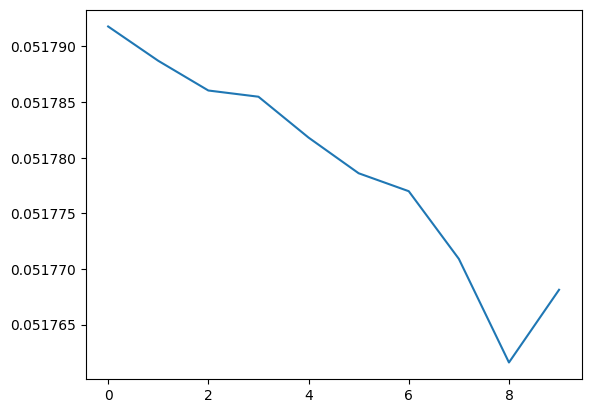

In [ ]:
model, training_losses = train(model, data_loader, epochs=10, beta=0.01, lr=1e-4, device=device)
plt.plot(training_losses)
plt.show()

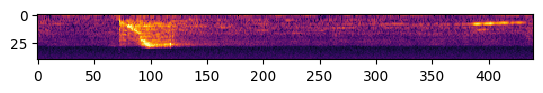

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x1100 and 4400x2)

In [ ]:
plt.imshow(dataset[0].cpu().detach().numpy().reshape(40, 440), cmap='inferno', interpolation='nearest')
plt.show()
plt.imshow(model(dataset[0])[0].cpu().detach().numpy().reshape(40, 440), cmap='inferno', interpolation='nearest')
plt.show()